In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential#( Keras allows you to build a sequential model, which is a common architecture for neural networks where layers are stacked one after another.)
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD #(Stochastic Gradient Descent optimizer, a common optimization algorithm used to train neural networks.)
import math
from sklearn.metrics import mean_squared_error

In [2]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
dataset = pd.read_csv(r'C:\Users\pratham\Desktop\Machine-Learning-Models\LSTM(Long_Short_Term_Memory)\Stock\AABA_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [4]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values #Selected specific column from 2016 column
test_set = dataset['2017':].iloc[:,1:2].values

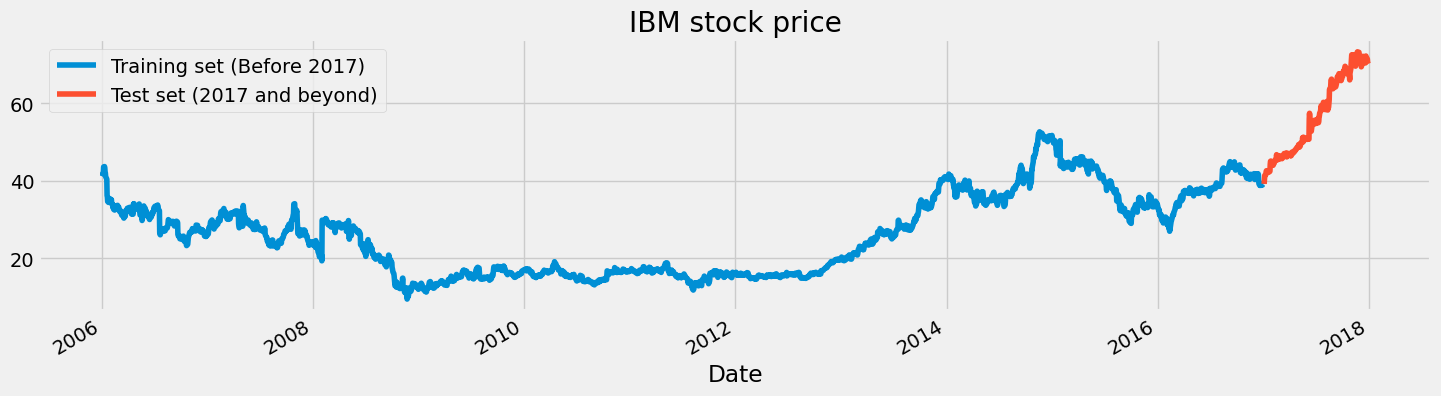

In [11]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [20]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
#This scaling is often performed to ensure that all features have similar scales, which can improve the performance of certain machine learning algorithms.








In [13]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)# allow for vectorized operations, which can significantly speed up computations.
#Vectorized operations refer to the ability to perform operations on entire arrays or matrices at once, without the need for explicit looping over individual elements.

In [14]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [9]:
# The LSTM architecture
regressor = Sequential() #creates an empty sequential model where layers can be added one by one.
# First LSTM layer with Dropout regularisation
# The number of LSTM units determines the capacity or complexity of the LSTM
#layer. Having more units allows the model to learn more complex patterns in the data.
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))# to prevent overfitting by randomly setting a fraction of input units to 0 during training.
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2)) #layers are added after each LSTM layer to prevent overfitting by randomly setting a fraction of input units to 0 during training. The dropout rate is set to 0.2.
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1)) #consists of a single neuron with a linear activation function
# simply outputs the weighted sum of the inputs, which is suitable for regression tasks where the goal is to predict continuous values.

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# The RMSprop optimizer is chosen(due to its effectiveness in handling various types of data and convergence properties.),
# and the mean squared error loss function is specified, which is commonly used for regression problems.
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)
#epoch refers to one complete pass through the entire training dataset
#number of samples processed before the model's parameters are updated during training





Epoch 1/50

85/85 [==============================] - 32s 195ms/step - loss: 0.0175
Epoch 2/50
85/85 [==============================] - 17s 198ms/step - loss: 0.0071
Epoch 3/50
85/85 [==============================] - 17s 204ms/step - loss: 0.0061
Epoch 4/50
85/85 [==============================] - 17s 204ms/step - loss: 0.0052
Epoch 5/50
85/85 [==============================] - 17s 201ms/step - loss: 0.0044
Epoch 6/50
85/85 [==============================] - 18s 211ms/step - loss: 0.0044
Epoch 7/50
85/85 [==============================] - 17s 202ms/step - loss: 0.0038
Epoch 8/50
85/85 [==============================] - 17s 195ms/step - loss: 0.0033
Epoch 9/50
85/85 [==============================] - 17s 198ms/step - loss: 0.0030
Epoch 10/50
85/85 [==============================] - 17s 199ms/step - loss: 0.0033
Epoch 11/50
85/85 [==============================] - 16s 194ms/step - loss: 0.0029
Epoch 12/50
85/85 [==============================] - 17s 196ms/step - loss: 0.0027
Epoch 13/5

In [15]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1) #The selected input data (inputs) is reshaped to have a single feature
inputs  = sc.transform(inputs)

In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 4s 57ms/step


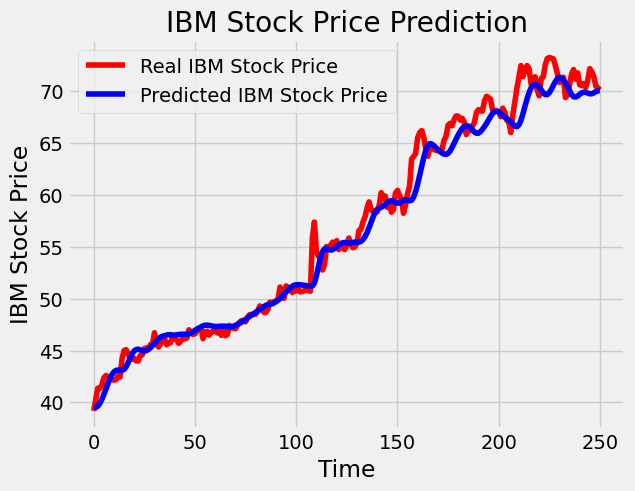

In [17]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [18]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.4619157542505226.
